# AM207 Final Project

Paper: *Learned Uncertainty-Aware (LUNA) Bases for Bayesian Regression using Multi-Headed Auxiliary Networks*

207Notes:
 - (sneaky 205 q) 
    - minimum of trace in obj function
    - consider step size stability in the cosine similar FD (larger h)
    - ADAM vs SGD w/ momentum vs cyclic annealling of learning rate

 - NOTE: NLM gets comparable to LUNA if there are more features

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys

# our libraries
import utils
from nlm import NLM
from feed_forward import Feedforward
import bayes_helpers as bh

### Generate Data

In [29]:

gap = True
if gap == True:
    number_of_points = 40
    x_train, y_train, x_test = utils.generate_data(number_of_points)
else:
    df = pd.read_csv("HW8_data.csv")
    x_train = np.array(df["x"])
    y_train = np.array(df["y"])
    x_test = np.linspace(x_train.min()-1,x_train.max()+1,200)

x_train = x_train.reshape((1, -1))
y_train = y_train.reshape((1, -1))
x_test = x_test.reshape((1, -1))




#### Define NN Hyperparameters

In [36]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 7
hidden_layers = 1
input_dim = 1
output_dim = 3

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':1500, 
          'random_restarts':1,
          'optimizer':'adam'}


Michael Scratch code for debugging finite differences

In [80]:
class dumb_NN():

    def __init__(self,D_in,D_out,ff):
        self.D_in = D_in
        self.D_out = D_out
        self.ff = ff
        
    def default_finite_diff(self, W,x):
        '''
        x.shape[0] is # of dimensions
        x.shape[1] is # of observations

        output: Returns a 3d matrix:
                (in dimension) x (out dimension (# of aux functions)) x (# observations)
        '''
        
        #create one epsilon for each observation
        eps = np.random.normal(0,0.1,size=x.shape[1])
        #print(eps.shape)

        #iterate over features of raw input data (rows of x)
        out = np.zeros((self.D_in, self.D_out, x.shape[1]))
        #print(out.shape)

        #evaluate function at x
        f_ex = self.ff.forward(W, x)

        #for one dimension at a time
        for i in range(x.shape[0]):

            delta = np.zeros(x.shape)
            delta[i,:] = eps
            #print(delta)
            f_eps = self.ff.forward(W,x+delta)
            print(f_eps.shape)
            # out dim X #obs
            print(out)
            out[i,:,:] = (f_eps - f_ex)/eps # value wise division, different epsilon for each column 
            print(out)

        return out

    def similarity_score(self, W, x):
        '''
        Calculates total sum of squared cosine similarity between all pairwise combinations of aux 
        functions
        
        Inputs: 
        - W = NumPy array of weights [dim=(1, width H, input dimension D_in)]

        Returns:
        - score = total cosine similarity squared across all pairs of functions [scalar]

        ''' 

        D_out = self.D_out
        score = 0
        #derivs of all the aux funcs
        holy_grail = self.default_finite_diff(W, x)
        # in dim x out dim x # obs
        M = holy_grail.shape[1]
        for i in range(D_out):
            grad_i = holy_grail[:,i,:]
            for j in range(i + 1, D_out):
                grad_j = holy_grail[:,j,:]
                score += self.cos_sim_sq(grad_i, grad_j)
        return score

    def cos_sim_sq(self,grad_i, grad_j):
        numer = np.dot(grad_i, grad_j.T)
        denom = (np.dot(grad_i,grad_i.T)*np.dot(grad_j,grad_j.T))
        return (numer/denom)[0][0]


In [37]:
    nn = Feedforward(architecture, random=random)

    #fit my neural network to minimize MSE on the given data
    nn.fit(x_train, y_train, params)

    #predict on the test x-values
    y_test_pred = nn.forward(nn.weights, x_test)

 Iteration 1000 lower bound 96.96464020148522; gradient mag: 120.45939449089421

In [83]:
out = dumb_NN(input_dim,output_dim,nn).default_finite_diff(nn.weights,x_train)

(1, 3, 80)
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
[[[ 1.81851717  1.81851717  1.81851717  1.81851717  1.81851717
    1.81851717  1.81851717  1.81851717  1.81851717  1.81851717
    1.81851717  1.81851717  1.81851717  1.81851717  1.81851717
    1.81851717  1.81851717  1.81851717 

### Run Vanilla Nueral Network

 Iteration 14000 lower bound 43.018091460735455; gradient mag: 2.7778689582874687(200, 1)


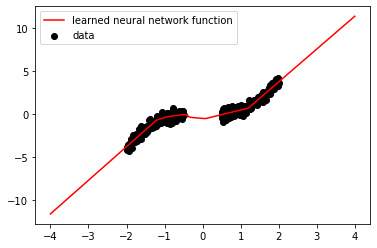

In [ ]:
utils.run_toy_nn(Feedforward,architecture,params,random,x_train,y_train,x_test)

### NLM Demo

In [ ]:
# test
prior_var = 1.0
y_var = 2.0
test_nlm = NLM(prior_var,y_var, architecture, random_state = np.random.RandomState(0))

In [ ]:
params = {'step_size':1e-3, 
          'max_iteration':1000, 
          'random_restarts':1,
          'optimizer':'adam'}
test_nlm.train(x_train,y_train, params)

 Iteration 0 lower bound 442.89870891894486; gradient mag: 953.4500692900577
Done Training


In [ ]:
posterior_predictives, posterior_predictive_samples = test_nlm.predict(x_test)

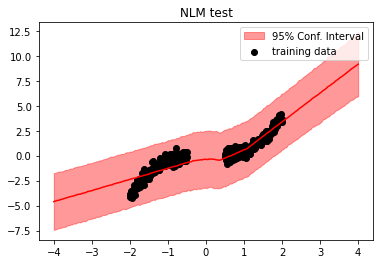

In [ ]:
bh.viz_pp_samples(x_train, y_train,x_test.flatten(),posterior_predictive_samples,"NLM test")